In [165]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
from itertools import product

from data_generation.visualization.create_plots import plot_2D_vector_field_over_grid
from data_generation.models.general_ode_solver import FitzHughNagumoModel, GeneralODENumericalSolver
from data_generation.models.tech_substitution import TechnologySubstitution, TechSubNumericalSolver
from data_generation.simulations.grid import Grid, fractional_transformation, logistic_transformation, tangent_transformation
from data_generation.visualization.create_plots import plot_2D_vector_field_over_grid

In [166]:
def get_gridcell_centers_and_derivatives(grid, solver, controls):
    """
    Calculates the grid cell centers and their derivatives for possibly multiple controls for a given grid and solver.
    
    Parameters:
    grid (Grid): The grid object containing the grid information and transformations.
    solver: The solver object used to compute the derivatives.
    controls (np.array): An array of control parameters for which the derivatives are computed.
    
    Returns:
    transformed_centers (np.array): The transformed centers of the grid cells.
    centers (np.array): The original centers of the grid cells.
    derivatives (np.array): The derivatives at the grid cell centers for each control parameter.
    transformed_derivates (np.array): The transformed derivatives at the grid cell centers for each control parameter.
    """
    
    transformed_centers = grid.get_cell_centers(transformed_space=True)
    centers = grid.get_cell_centers()
    num_centers = np.prod(grid.resolution)
    derivatives = np.zeros((controls.shape[0], num_centers, grid.dimension))
    transformed_derivates = np.zeros((controls.shape[0], num_centers, grid.dimension))

    for k, c in enumerate(controls):
        derivatives[k] = solver.get_derivative(centers, controls[k])
        #Transform the vectorfield, multiply with Jacobian of transformation
        for i in range(grid.dimension):
            transformed_derivates[k, :, i] = np.multiply(np.vectorize(grid.transformation_derivatives[i])(centers[:,i]), derivatives[k,:,i])

    return centers, transformed_centers, derivatives, transformed_derivates



In [167]:
def plot_grid_gradients_and_vectorfield(grid, solver, controls, transformed_centers, transformed_derivatives):
    # Extract the x and y coordinates of the transformed centers
    x = transformed_centers[:, 0]
    y = transformed_centers[:, 1]

    td = transformed_derivatives

    # Create the quiver plot
    fig, axes = plt.subplots(figsize=(6, 6))
    cmap = plt.get_cmap('Accent')
    norm = pltcol.Normalize(vmin=0, vmax=controls.shape[0] - 1)  # Normalize indices
    for i in range(controls.shape[0]):
        plt.quiver(x, y, td[i, :, 0], td[i, :, 1], angles='xy', scale_units='xy', scale=1, width=0.002, color=cmap(norm(i)))
    

    plot_2D_vector_field_over_grid(grid, solver, control = controls[0], axis_names=['v','w'], 
                                title='', display_nullclines=False, 
                                ax = axes, display_grid=True, 
                                display_streamplot= True,
                                broken_streamlines=False, streamplot_colour=(0.1,0.4,0.8,0.4))


In [168]:
fmodel = FitzHughNagumoModel(control_params=['b','I'])
fsolver = GeneralODENumericalSolver(fmodel)
fhnbounds = [(-np.inf,np.inf),(-np.inf,np.inf)]
fhnres = [10,10]
log_trafos = [logistic_transformation({'k': 1, 'x_0': 0}), logistic_transformation({'k': 1, 'x_0': 0})]
fhngrid = Grid(fhnbounds, fhnres, log_trafos)

In [169]:
controls = np.array([[2, 0], [0.5, 0.35]])
centers, transformed_centers, derivatives, transformed_derivatives = get_gridcell_centers_and_derivatives(fhngrid,fsolver, controls)

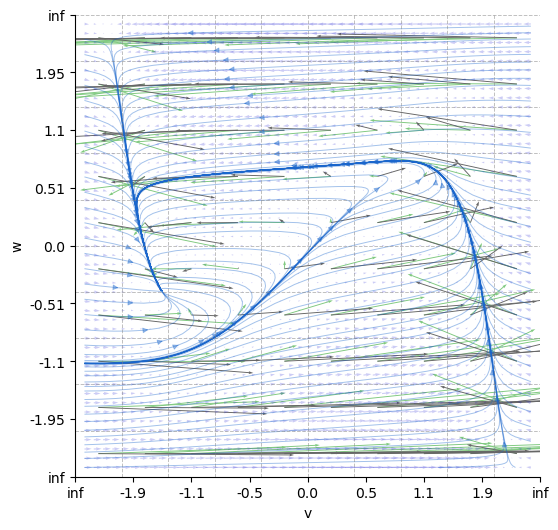

In [170]:
plot_grid_gradients_and_vectorfield(fhngrid, fsolver, controls, transformed_centers, transformed_derivatives)

In [173]:
tmodel = TechnologySubstitution(D0=1.0, delta=1.0, sigma=0.2, alpha=0.5, gamma1=1.0)
tsolver = TechSubNumericalSolver(tmodel)
tinfbounds = [(0, np.inf), (0, np.inf)]
tres = [10,10]
fract_trafos = [fractional_transformation(3.0), fractional_transformation(3.0)]
tgrid = Grid(tinfbounds, tres, fract_trafos)
tcontrols = np.array([1, 0.5])

In [174]:
centers, transformed_centers, derivatives, transformed_derivatives = get_gridcell_centers_and_derivatives(fhngrid,fsolver, controls)

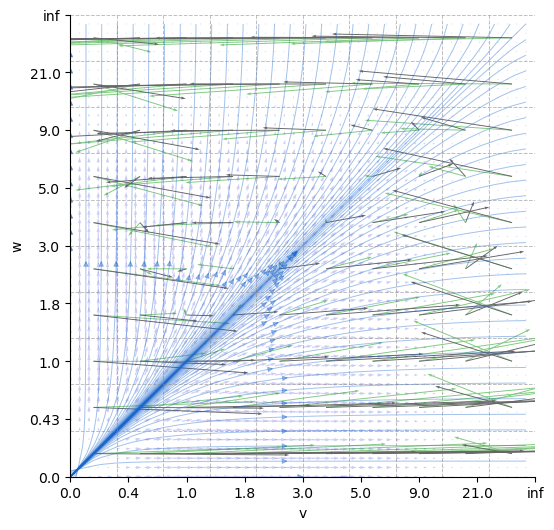

In [ ]:
plot_grid_gradients_and_vectorfield(tgrid, tsolver, tcontrols, transformed_centers, transformed_derivatives) #sth wrong!?!